<a href="https://colab.research.google.com/github/dscer/DS6050_Codeathon_3/blob/main/ybt7qf_codeathon_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install keras_nlp -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 28.5 MB/s eta 0:00:00


# GPT Text Generation Tutorial (Gutenberg dataset)

In [2]:
import os
import math
import time
import keras
import keras_nlp
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

Using TensorFlow backend


## Settings & hyperparameters

In [3]:
# Data
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 450

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000  # Limits parameters in model.

# Training
EPOCHS = 6

# Inference
NUM_TOKENS_TO_GENERATE = 80

## Load the data

In [ ]:
keras.utils.get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
)
dir = os.path.expanduser("~/.keras/datasets/simplebooks/")

# Load simplebooks-92 train set and filter out short lines.
raw_train_ds = (
    tf.data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

# Load simplebooks-92 validation set and filter out short lines.
raw_val_ds = (
    tf.data.TextLineDataset(dir + "simplebooks-92-raw/valid.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
)

282386239/282386239 [==============================] - 17s 0us/step


## Train the tokenizer

In [ ]:
# Train tokenizer vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

## Load tokenizer

In [ ]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

## Tokenize data

In [ ]:
# packer adds a start token
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)


def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

## Build the model

In [ ]:
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
# Embedding.
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         1312768   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_decoder (Trans  (None, None, 256)         394749    
 formerDecoder)                                                  
                                                                 
 transformer_decoder_1 (Tra  (None, None, 256)         394749    
 nsformerDecoder)                                                
                                                                 
 dense (Dense)               (None, None, 5000)        128500

## Training

In [ ]:
model.fit(train_ds, validation_data=val_ds, verbose=2, epochs=EPOCHS)

Epoch 1/6
3169/3169 - 319s - loss: 4.4812 - perplexity: 88.6913 - val_loss: 4.1165 - val_perplexity: 61.9511 - 319s/epoch - 101ms/step
Epoch 2/6
3169/3169 - 239s - loss: 4.0394 - perplexity: 57.0122 - val_loss: 3.9519 - val_perplexity: 52.4437 - 239s/epoch - 75ms/step
Epoch 3/6
3169/3169 - 238s - loss: 3.9314 - perplexity: 51.1697 - val_loss: 3.9160 - val_perplexity: 50.6152 - 238s/epoch - 75ms/step
Epoch 4/6
3169/3169 - 239s - loss: 3.8718 - perplexity: 48.2092 - val_loss: 3.8535 - val_perplexity: 47.4732 - 239s/epoch - 75ms/step
Epoch 5/6
3169/3169 - 240s - loss: 3.8319 - perplexity: 46.3231 - val_loss: 3.8592 - val_perplexity: 47.7375 - 240s/epoch - 76ms/step
Epoch 6/6
3169/3169 - 238s - loss: 3.8019 - perplexity: 44.9526 - val_loss: 3.8218 - val_perplexity: 46.0149 - 238s/epoch - 75ms/step


## Inference

In [ ]:
# The "packer" layers adds the [BOS] token for us.
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [ ]:
def next(prompt, cache, index):
    logits = model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache

### Greedy search


In [ ]:
sampler = keras_nlp.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

Greedy search generated text: 
[b'[BOS] " i \' ve been thinking of it , " said the doctor , " but i \' ve been thinking of it . i \' ve been thinking of it , and i \' ve been thinking of it . i \' ve been thinking of it , but i \' ve been thinking of it . i \' ve been thinking of it , but i \' ve been thinking of it . i \' ve been thinking of it , and i \' ve been thinking of it . i \' ve been thinking of it , but i \' ve never been able to see it . i \' ve been thinking of it , and i \' ve been thinking of it']



### Beam search

In [ ]:
sampler = keras_nlp.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

Beam search generated text: 
[b'[BOS] " yes , sir , " he said , " it \' s all right , and i \' m going to tell you . i \' m going to tell you , and i \' m going to tell you . i \' m going to tell you what i \' m going to tell you . i \' m going to tell you . i \' m going to tell you . i \' m going to tell you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .']



### Random search

In [ ]:
sampler = keras_nlp.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

Random search generated text: 
[b'[BOS] so the fat meg bade her , when his legs stuck his legs up all little white . then she tried to stagger him , and have played with him just as she was about as much fun as she had stood on the little body to mamma , and ask him whether she was safely down with the burg off to the blackboard side of his head . [PAD] aginswa was covered with thick scakes . " well , the first and then felt very nice , " said both mr . bowde \' s face , " why didn \' t i like to go on ! what do that is those brown']



### Top-K search

In [ ]:
sampler = keras_nlp.samplers.TopKSampler(k=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

Top-K search generated text: 
[b'[BOS] " it has not been for a time , " the captain told the man , who were sitting in the boat , " was the only one . " the other man said , " we are going to be the best part . we are all going west and we are going to try the boat . i suppose it was about twenty years since we have got there . it has not been the same as the captain of the steamer , though he may be , for the navy is that i should have made the commander of our boat . " [PAD] " he was very likely to have taken the wheel , and he was in the hands of the boys']



### Top-P search


In [ ]:
sampler = keras_nlp.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
[b'[BOS] the pearls were almost as dark as ever . the descendants , with their usual force . they were not at all like a large commissary of the enemy , but the saxons were too powerful to fight , and the english were not appalling . in a few minutes they were indifferently and with abundant supply of provisions , and the desolation of the french , the rivulets of the fragrants , the saxons had not been more successful . the dutchmen were so greatly superior to the british']



### Using callbacks for text generation

In [ ]:
class TopKTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-k."""

    def __init__(self, k):
        self.sampler = keras_nlp.samplers.TopKSampler(k)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"Top-K search generated text: \n{txt}\n")


text_generation_callback = TopKTextGenerator(k=10)
# Dummy training loop to demonstrate callback.
model.fit(train_ds.take(1), verbose=2, epochs=2, callbacks=[text_generation_callback])

Epoch 1/2
Top-K search generated text: 
[b'[BOS] " i don \' t suppose it will be a great deal worse , " replied mildred , " but we \' re not to apprehensible . we \' d have had some time in my house . it \' s a very hard place . now , it \' s my only home in my heart , " ( " and it \' s all in the way , that \' s what i \' ve got to say when they \' m not going to . that \' s just a little better than that , because you \' ve made up your mind that i \' ve got to do . " and when i got']

1/1 - 11s - loss: 3.9863 - perplexity: 53.9622 - 11s/epoch - 11s/step
Epoch 2/2
Top-K search generated text: 
[b"[BOS] the little girl ran to see how the little boy had got . he was very much frightened when he was away . the little man had told the boy how he had been . he thought of nothing but to his father ' s father and the boy had had a hard time . the boy had been able to keep his eyes on the boy ' s . the little boy had been a child , and his father was as a child , and the old man , but when h

# Text Generation with KerasNLP (Reddit dataset)


## Preprocess Reddit dataset

In [4]:
reddit_ds = tfds.load("reddit_tifu", split="train", as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/79740 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/reddit_tifu/short/1.1.2.incompleteQ11GGF/reddit_tifu-train.tfrecord*...:  …

Dataset reddit_tifu downloaded and prepared to /root/tensorflow_datasets/reddit_tifu/short/1.1.2. Subsequent calls will reuse this data.


In [5]:
for document, title in reddit_ds:
    print(document.numpy())
    print(title.numpy())
    break

b"me and a friend decided to go to the beach last sunday. we loaded up and headed out. we were about half way there when i decided that i was not leaving till i had seafood. \n\nnow i'm not talking about red lobster. no friends i'm talking about a low country boil. i found the restaurant and got directions. i don't know if any of you have heard about the crab shack on tybee island but let me tell you it's worth it. \n\nwe arrived and was seated quickly. we decided to get a seafood sampler for two and split it. the waitress bought it out on separate platters for us. the amount of food was staggering. two types of crab, shrimp, mussels, crawfish, andouille sausage, red potatoes, and corn on the cob. i managed to finish it and some of my friends crawfish and mussels. it was a day to be a fat ass. we finished paid for our food and headed to the beach. \n\nfunny thing about seafood. it runs through me faster than a kenyan \n\nwe arrived and walked around a bit. it was about 45min since we a

In [6]:
train_ds = (
    reddit_ds.map(lambda document, _: document)
    .batch(32)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

## Fine-tune Pre-Trained Models

### Reusable Training Configs

In [7]:
train_ds = train_ds.take(500)
num_epochs = 1

In [8]:
# Linearly decaying learning rate.
learning_rate = keras.optimizers.schedules.PolynomialDecay(
    5e-5,
    decay_steps=train_ds.cardinality() * num_epochs,
    end_learning_rate=0.0,
)

In [9]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Callbacks

In [10]:
class GPUMemoryCallback(keras.callbacks.Callback):
    def __init__(
        self,
        target_batches,
        print_stats=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.target_batches = target_batches
        self.print_stats = print_stats

        self.memory_usage = []
        self.labels = []

    def _compute_memory_usage(self):
        memory_stats = tf.config.experimental.get_memory_info("GPU:0")
        # Convert bytes to GB and store in list.
        peak_usage = round(memory_stats["peak"] / (2**30), 3)
        self.memory_usage.append(peak_usage)

    def on_epoch_begin(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} start")

    def on_train_batch_begin(self, batch, logs=None):
        if batch in self.target_batches:
            self._compute_memory_usage()
            self.labels.append(f"batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} end")

### General Functions

In [11]:
def generate_text(model, input_text, max_length=200):
    start = time.time()

    output = model.generate(input_text, max_length=max_length)
    print("\nOutput:")
    print(output)

    end = time.time()
    print(f"Total Time Elapsed: {end - start:.2f}s")

In [12]:
def plot_memory_use(model_list: list, memory_use: dict):
    plt.bar(
      model_list,
      [max(v) for k, v in memory_use.items()],
      color=["red", "blue", "green", "orange", "cyan"],
    )

    plt.xlabel("Time")
    plt.ylabel("GPU Memory Usage (in GB)")

    plt.title("GPU Memory Usage Comparison")
    plt.legend()
    plt.show()

### GPT2 Models

In [14]:
gpt2_model_list = [
    "gpt2_base_en",
    # "gpt2_medium_en",
    # "gpt2_large_en",
    # "gpt2_extra_large_en",
]

gpt2_memory_use = {}

for model_name in gpt2_model_list:

    print(f"\n-------- Training {model_name} ---------------\n")

    preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
        model_name,
        sequence_length=128,
    )
    tmp_lm = keras_nlp.models.GPT2CausalLM.from_preset(
        model_name, preprocessor=preprocessor
    )

    tmp_lm.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        weighted_metrics=["accuracy"],
    )

    gpu_memory_callback = GPUMemoryCallback(
        target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
        print_stats=True,
    )

    tmp_lm.fit(train_ds,
               epochs=num_epochs,
               callbacks=[gpu_memory_callback])

    gpt2_memory_use[model_name] = gpu_memory_callback.memory_usage

    generate_text(tmp_lm, "I like basketball")


-------- Training gpt2_base_en ---------------

  6/500 [..............................] - ETA: 9:14 - loss: 3.6633 - accuracy: 0.2901

500/500 [==============================] - 712s 1s/step - loss: 3.3045 - accuracy: 0.3262

Output:
I like basketball. i like basketball so much, that it's almost always on my computer when i play it. i don't know if i'll be able to do that today, but my parents are very strict with it.

so, this morning, i was playing basketball on my phone with my dad (who is also a basketball coach), my girlfriend (who was playing basketball with me), and the two of them, i was playing basketball and my girlfriend and my brother were playing basketball. i was in a hurry to get home, and i was in the middle of the floor. 

i was sitting on the floor, and i was playing basketball
Total Time Elapsed: 22.34s


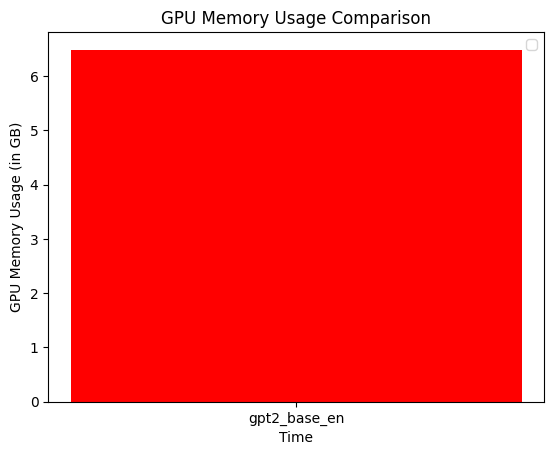

In [15]:
plot_memory_use(gpt2_model_list, gpt2_memory_use)

## OPT Models

In [16]:
opt_model_list = [
    "opt_125m_en",
    # "opt_1.3b_en",
    # "opt_2.7b_en",
    # "opt_6.7b_en"
]

opt_memory_use = {}

for model_name in opt_model_list:

    print(f"\n-------- Training {model_name} ---------------\n")

    preprocessor = keras_nlp.models.OPTCausalLMPreprocessor.from_preset(
        model_name,
        sequence_length=128,
    )
    tmp_lm = keras_nlp.models.OPTCausalLM.from_preset(
        model_name, preprocessor=preprocessor
    )

    tmp_lm.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        weighted_metrics=["accuracy"],
    )

    gpu_memory_callback = GPUMemoryCallback(
        target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
        print_stats=True,
    )

    tmp_lm.fit(train_ds,
               epochs=num_epochs,
               callbacks=[gpu_memory_callback])

    opt_memory_use[model_name] = gpu_memory_callback.memory_usage

    generate_text(tmp_lm, "I like basketball")


-------- Training opt_125m_en ---------------

  6/500 [..............................] - ETA: 9:55 - loss: 3.3430 - accuracy: 0.3266 

500/500 [==============================] - 642s 1s/step - loss: 3.1035 - accuracy: 0.3516

Output:
I like basketball and i'm a big fan of it and i was playing with the other kids at the school. we were playing in a field and my brother was playing in the back and we were playing with his brother. i thought i was the only one in the whole school, i was just sitting in the front. i was just standing there, watching the game and i thought i was the only one. i was right. my brother was in the corner of the field, i was just sitting and i saw him standing there, i didn't see him and i didn't hear him. my friend was standing behind me and
Total Time Elapsed: 16.27s


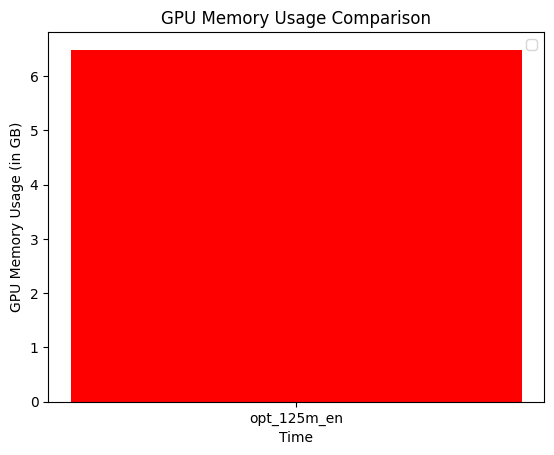

In [17]:
plot_memory_use(opt_model_list, gpt2_memory_use)

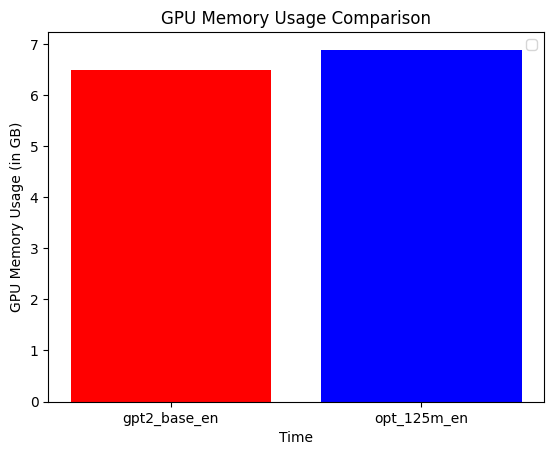

In [18]:
plot_memory_use(gpt2_model_list + opt_model_list,
                gpt2_memory_use | opt_memory_use)

## LoRA
Source: https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/

In [13]:
class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )
        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output

In [19]:
def get_optimizer_and_loss():
    optimizer = keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=0.01,
        epsilon=1e-6,
        global_clipnorm=1.0,  # Gradient clipping.
    )
    # Exclude layernorm and bias terms from weight decay.
    optimizer.exclude_from_weight_decay(var_names=["bias"])
    optimizer.exclude_from_weight_decay(var_names=["gamma"])
    optimizer.exclude_from_weight_decay(var_names=["beta"])

    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return optimizer, loss

###  GPT2

In [20]:
# This resets "peak" memory usage to "current" memory usage.
tf.config.experimental.reset_memory_stats("GPU:0")

# Load the original model.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
lora_gpt2_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

In [21]:
# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

for layer_idx in range(lora_gpt2_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_gpt2_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

In [22]:
lora_gpt2_model(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])
pass

In [23]:
for layer in lora_gpt2_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [24]:
lora_gpt2_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer_1 (GPT2Tokenizer)                   │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone_1 (GPT2Backbone)                │ (None, None, 768)                      │     124,587,264 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50257)                    │      38,597,376 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 124,439,808 (474.70 MB)

In [25]:
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,
)

optimizer, loss = get_optimizer_and_loss()

lora_gpt2_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

lora_gpt2_model.fit(
    train_ds,
    epochs=1,
    callbacks=[gpu_memory_callback],
)
lora_gpt2_model_memory_usage = gpu_memory_callback.memory_usage

  6/500 [..............................] - ETA: 7:57 - loss: 3.8260 - accuracy: 0.2758

500/500 [==============================] - 500s 919ms/step - loss: 3.5418 - accuracy: 0.3006


In [26]:
for layer_idx in range(lora_gpt2_model.backbone.num_layers):
    self_attention_layer = lora_gpt2_model.backbone.get_layer(
        f"transformer_layer_{layer_idx}"
    )._self_attention_layer

    # Merge query dense layer.
    query_lora_layer = self_attention_layer._query_dense

    A_weights = query_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = query_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    query_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # Merge value dense layer.
    value_lora_layer = self_attention_layer._value_dense

    A_weights = value_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = value_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    value_lora_layer.original_layer.kernel.assign_add(increment_weights)

In [27]:
generate_text(lora_gpt2_model, "I like basketball")


Output:
I like basketball. it's not a great experience, but at least it wasn't bad. 

i'm a sophomore at the college.    

i was in class last week, which was a pretty big deal.      i'm a freshman, so i was going to go to a basketball game.
               
                                                                                                               
Total Time Elapsed: 20.31s


### OPT

In [29]:
# This resets "peak" memory usage to "current" memory usage.
tf.config.experimental.reset_memory_stats("GPU:0")

# Load the original model.
preprocessor = keras_nlp.models.OPTCausalLMPreprocessor.from_preset(
    "opt_125m_en",
    sequence_length=128,
)
lora_opt_model = keras_nlp.models.OPTCausalLM.from_preset(
    "opt_125m_en",
    preprocessor=preprocessor,
)

In [30]:
# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

for layer_idx in range(lora_opt_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_opt_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

In [31]:
lora_opt_model(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])
pass

In [32]:
for layer in lora_opt_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [33]:
lora_opt_model.summary()

Preprocessor: "opt_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ opt_tokenizer_1 (OPTTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "opt_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ opt_backbone_1 (OPTBackbone)                  │ (None, None, 768)                      │     125,385,216 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50272)                    │      38,608,896 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 125,385,216 (478.31 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 125,237,760 (477.74 MB)

In [34]:
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,
)

optimizer, loss = get_optimizer_and_loss()

lora_opt_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

lora_opt_model.fit(
    train_ds,
    epochs=1,
    callbacks=[gpu_memory_callback],
)
lora_opt_model_memory_usage = gpu_memory_callback.memory_usage

  6/500 [..............................] - ETA: 7:54 - loss: 3.4192 - accuracy: 0.3176

500/500 [==============================] - 484s 892ms/step - loss: 3.2691 - accuracy: 0.3305


In [35]:
for layer_idx in range(lora_opt_model.backbone.num_layers):
    self_attention_layer = lora_opt_model.backbone.get_layer(
        f"transformer_layer_{layer_idx}"
    )._self_attention_layer

    # Merge query dense layer.
    query_lora_layer = self_attention_layer._query_dense

    A_weights = query_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = query_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    query_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # Merge value dense layer.
    value_lora_layer = self_attention_layer._value_dense

    A_weights = value_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = value_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    value_lora_layer.original_layer.kernel.assign_add(increment_weights)

In [36]:
generate_text(lora_opt_model, "I like basketball")


Output:
I like basketball, so it's been a while, but i've been a little bit drunk. 

my parents have lived here for a long time, and have been living here for years. we have a small apartment, which we use for our daily living. i have to go to bed at 5am, and then wake up at 6am, usually at 6. 


so we're living in a small apartment, with no kitchen, but the living room, which is pretty small. we've been living in a small apartment for about 2 years
Total Time Elapsed: 19.69s


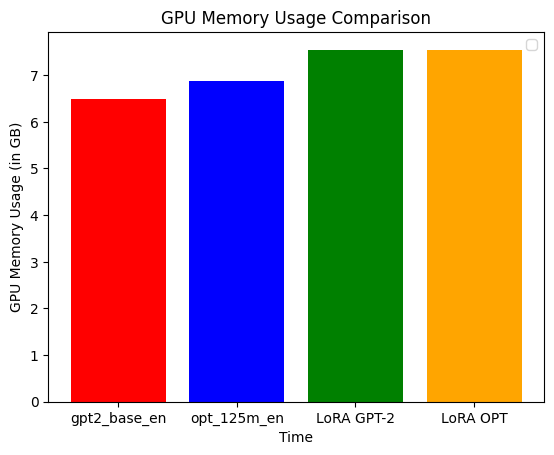

In [38]:
plot_memory_use(gpt2_model_list + opt_model_list + ["LoRA GPT-2", "LoRA OPT"],
                gpt2_memory_use | opt_memory_use | {"LoRA GPT-2": lora_opt_model_memory_usage, "LoRA OPT": lora_opt_model_memory_usage})